In [2]:
!pip install opencv-python

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.svm import SVC
from sklearn.ensemble import *

from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer

from sklearn.cross_validation import StratifiedKFold, train_test_split, StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import GridSearchCV

In [4]:
X, y = load_svmlight_file('./digits/digit_train')

print(X[0].shape)
X = X.toarray()
print(X.shape)

(1, 771)
(500, 771)


In [5]:
zeros = np.zeros((X.shape[0],28*28- X.shape[1]))
X = np.concatenate((X, zeros), axis = 1)
X_train = X
y_train = y

In [6]:
X = X.reshape((len(X), 28, 28))

In [7]:
def plotSamples( no_samples, data, y ):
    for i in range(no_samples):
        plt.subplot(1,no_samples, i+1)
        plt.imshow(data[i], cmap= 'gray')
        plt.axis('off')
        plt.title((int(y[i])))

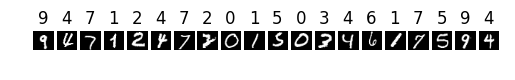

In [8]:
plotSamples(20, X, y)

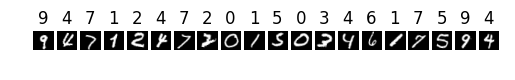

In [9]:
def rotateImages( data, degree ):
    new_data = []
    rows,cols = 28, 28
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degree,1)
    for img in data:
        new_data.append(cv2.warpAffine(img,M,(rows,cols)))
    return new_data
rotates = rotateImages(X, -10)
plotSamples(20, rotates, y)

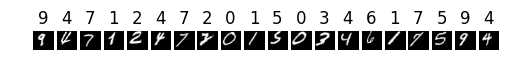

In [10]:
def distortImages( data, pts1, pts2 ):
    new_data = []
    rows,cols = 28, 28
    M = cv2.getAffineTransform(pts1,pts2)
    for img in data:
        new_data.append(cv2.warpAffine(img,M,(cols,rows)))
    return new_data

pts1 = np.float32([[3,3],[26,26],[26,3]])
pts2 = np.float32([[3,3],[20,20],[24,0]])
dist_images = distortImages( X, pts1, pts2 )
plotSamples(20, dist_images, y)

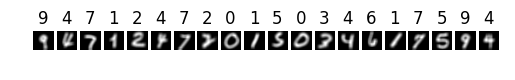

In [11]:
def blurImages( data, blur_param ):
    new_data = []
    rows,cols = 28, 28
    for img in data:
        new_data.append(cv2.GaussianBlur(img,(5,5),blur_param))
    return new_data
blurred_image = blurImages( X, 5 )
plotSamples(20, blurred_image, y)

In [12]:
np.concatenate( [[1],[2]], )

array([1, 2])

In [13]:
def extend_training_data(data, y, new_sets):
    new_data = data
    for ns in new_sets:
        new_data = np.concatenate((new_data, np.asarray(ns).reshape(data.shape)), axis = 0)
        
    new_data = new_data.reshape((new_data.shape[0],new_data.shape[1]*new_data.shape[2]))
    avg = new_data.mean()
    new_data = (new_data*1.0 - avg)/255.0

    new_y  = np.tile( y, len(new_sets) + 1 )
    return new_data, new_y, avg


X_train, Y_train,_ = extend_training_data(X, y, [blurred_image, rotates])
print("X_shape")
print(X_train.shape)
print("Y_shape")
print(Y_train.shape)

X_shape
(1500, 784)
Y_shape
(1500,)


In [15]:
clf = SVC(C = 4, gamma = 0.03125)
normalized_X = X.reshape( ( X.shape[0], X.shape[1]*X.shape[2] ))
normalized_X = (normalized_X - normalized_X.mean())/255
scores = cross_val_score(clf, normalized_X, y, cv=10, scoring="accuracy")
print(scores)

[ 0.87272727  0.87037037  0.92307692  0.88        0.92        0.97959184
  0.91836735  0.875       0.89361702  0.7826087 ]


In [16]:
def grid_search(X,y):
    C_range = np.logspace(-6, 10, num= 9, base=2)
    gamma_range = np.logspace(-5, 9, num= 8, base=2)
    param_grid = dict(gamma=gamma_range, C=C_range)
#     cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10, scoring="accuracy")
    grid.fit(X, y)
    # Without image augmentation we reach cv_acc = 0.9
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

grid_search( normalized_X, y)

The best parameters are {'C': 4.0, 'gamma': 0.03125} with a score of 0.89


In [17]:
scores = cross_val_score(clf, normalized_X, y, cv=10, scoring="accuracy")
print(scores)

[ 0.87272727  0.87037037  0.92307692  0.88        0.92        0.97959184
  0.91836735  0.875       0.89361702  0.7826087 ]


In [18]:
X_train, Y_train,_ = extend_training_data(X, y, [blurred_image, rotates])
clf = SVC(C = 4, gamma = 0.03125)
print("X_shape")
print(X_train.shape)
print("Y_shape")
print(Y_train.shape)
print("Training set with blurred and rotated extension")
scores = cross_val_score(clf, X_train, Y_train, cv=10, scoring="accuracy")
print(scores)

X_shape
(1500, 784)
Y_shape
(1500,)
Training set with blurred and rotated extension
[ 1.          1.          1.          0.94736842  0.96688742  0.98
  0.96621622  0.99319728  1.          1.        ]


In [19]:
train_X, test_X, train_y, test_y = train_test_split( normalized_X, y, test_size=0.33, random_state=42)

model = SVC(C = 4)
model.fit( train_X, train_y)
preds = model.predict( test_X )

print(accuracy_score(preds, test_y))

0.866666666667


In [34]:
def do_augmentations(X, y):
    rotates = rotateImages( X, -10)
    pts1 = np.float32([[3,3],[26,26],[26,3]])
    pts2 = np.float32([[3,3],[20,20],[24,0]])
    dist_images = distortImages( X, pts1, pts2 )    
    blurred_images = blurImages( X, 5 )
    extension = [ rotates, dist_images, blurred_images  ]
    current_train_x, current_train_y, avg = extend_training_data(X, y, extension )
    
    return current_train_x, current_train_y, lambda x: (x - avg )*1.0/255.0

In [39]:
def my_cross_validation( model_generator, X, y, fold = 10 ):
    results = np.zeros( (fold, 2) )
    kf = StratifiedKFold(y, fold)
    print("%d-fold validation " % fold )
    scores = []
    
    arr_X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
    
    for train_index, test_index in kf:
        model = model_generator()
        
        current_train_x = X[train_index,:] 
        current_train_y = y[train_index]
            
        rotates = rotateImages( current_train_x, -10)
        pts1 = np.float32([[3,3],[26,26],[26,3]])
        pts2 = np.float32([[3,3],[20,20],[24,0]])
        dist_images = distortImages( current_train_x, pts1, pts2 )    
        blurred_images = blurImages( current_train_x, 5 )
        extension = [ rotates, dist_images, blurred_images  ]
#         extension = [ blurred_images ]

#         extension = []
        current_train_x, current_train_y, norm_func = do_augmentations(current_train_x, current_train_y)
        

        model.fit( current_train_x, current_train_y)

        preds = model.predict( norm_func(arr_X[test_index,:]))
        scores.append( accuracy_score(preds, y[test_index]) )

    print("avg acc : %2.2f%% 士 %2.2f" % ( np.mean(scores) * 100, np.std(scores) ) ) 
    return ( np.mean(scores), np.std(scores) )
gen_svm = lambda:  SVC(C=4, gamma=0.03125)
my_cross_validation( gen_svm , X, y, 10 )

10-fold validation 
avg acc : 92.01% 士 0.04


(0.92013646309688346, 0.039333019160179415)

In [21]:

criterion = ['gini', 'entropy']
n_estimators = [10,15,20,25,50,100]
param_grid = dict(criterion=criterion, n_estimators=n_estimators)

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10, scoring="accuracy")
grid.fit(normalized_X, y)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'criterion': 'gini', 'n_estimators': 100} with a score of 0.87


In [25]:
# my_cross_validation( lambda:  RandomForestClassifier(n_estimators=100, criterion="entropy"), X, y, 10 )
my_cross_validation( lambda:  RandomForestClassifier(), X, y, 10 )

10-fold validation 
avg acc : 77.28% 士 0.04


(0.77282341944308386, 0.035880738680652967)

(500, 784)
(500, 28, 28)


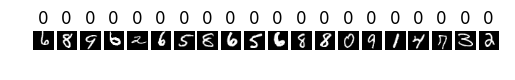

In [64]:
test_X, _ = load_svmlight_file('./digits/digit_test')
test_X = test_X.toarray()
zeros = np.zeros((test_X.shape[0],28*28- test_X.shape[1]))

test_X = np.concatenate((test_X, zeros), axis = 1)
print(test_X.shape)
test_X_3_dims = test_X.reshape((len(test_X), 28, 28))
print(test_X_3_dims.shape)
plotSamples( 20, test_X_3_dims, np.zeros(test_X.shape[0]) )

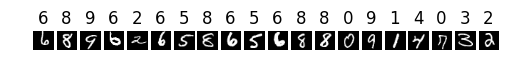

In [67]:
def train_and_predict(model, train_x, train_y, test_x):

    train_x, train_y, norm_func = do_augmentations( train_x, train_y )
    model.fit(train_x, train_y)
    
    return model.predict( norm_func(test_x) )

# Final train
final_preds = train_and_predict( SVC(C=4, gamma=0.03125), X, y, test_X )
plotSamples( 20, test_X_3_dims, final_preds )

In [78]:
def write_output( preds ) :    
    f = open('output.txt', 'w')
    f.write( "\n".join( map( lamba x: "%", preds ) ) )
    f.close()
write_output(final_preds)

TypeError: sequence item 0: expected str instance, int found